In [3]:
import numpy as np
import pandas as pd
from arch import arch_model
import statsmodels.formula.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.special import gamma
import scipy.stats as stats

In [4]:
##import the data
data=pd.read_csv('Downloads\Apple.csv',parse_dates=True)
##make date as index. 
##change date format 
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index("Date", inplace=True)
data.head()

,SP500,Apple
Date,,
1999-12-31,1469.250000,2.485700
2000-01-03,1455.219971,2.706315
2000-01-04,1399.420044,2.478144
2000-01-05,1402.109985,2.514410
2000-01-06,1403.449951,2.296816


In [5]:
##log return of apple and sp500
R1t=data['SP500']
R1t=100*np.log10(1+R1t.pct_change().dropna())
R2t=data['Apple']
R2t=100*np.log10(1+R2t.pct_change().dropna())

In [6]:
##SP500--student t 
am1=arch_model(R1t,p=1,o=1,q=1,dist='StudentsT')
resR1t=am1.fit()
print(resR1t.summary())
sigma1=resR1t.conditional_volatility
z1=resR1t.resid/sigma1
z1=(z1-z1.mean())/z1.std()
##APPLE-- student t
am2=arch_model(R2t,p=1,o=1,q=1,dist='StudentsT')
resR2t=am2.fit()
resR2t.summary()
sigma2=resR2t.conditional_volatility
z2=resR2t.resid/sigma2
z2=(z2-z2.mean())/z2.std()



Iteration:      1,   Func. Count:      8,   Neg. LLF: 2275.00764903936
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2274.970496736821
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2271.0902533558874
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2261.6836276499007
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2259.672376572375
Iteration:      6,   Func. Count:     58,   Neg. LLF: 2257.0200792103096
Iteration:      7,   Func. Count:     67,   Neg. LLF: 2255.863760397715
Iteration:      8,   Func. Count:     76,   Neg. LLF: 2254.4286477743917
Iteration:      9,   Func. Count:     85,   Neg. LLF: 2254.075635202681
Iteration:     10,   Func. Count:     94,   Neg. LLF: 2253.569190216979
Iteration:     11,   Func. Count:    102,   Neg. LLF: 2252.5882876343653
Iteration:     12,   Func. Count:    110,   Neg. LLF: 2252.561109712864
Iteration:     13,   Func. Count:    118,   Neg. LLF: 2252.5605775372815
Iteration:     14,   Func. Count:    126,   Neg. LLF: 2252.

Text(0,0.5,'$z2$')

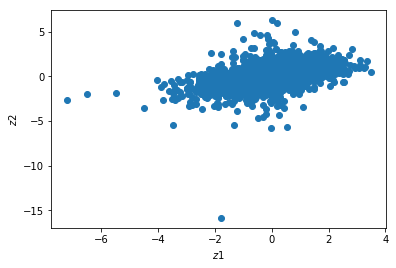

In [7]:
##plot z1 against z2
plt.scatter(z1,z2)
plt.xlabel('$z1$')
plt.ylabel('$z2$')

In [8]:
##correlation between z1 and z2
corr=np.corrcoef(z1,z2)
print(corr)

[[1.         0.50444736]
 [0.50444736 1.        ]]


In [10]:
##Estimate the conditional correlation(EWMA)
##EWMA method to z1 z2 and z1*z2
#Input parameter λ = 0.94 (so alpha = 0.06 in the built-in Pandas procedure)
labda = 0.94
z1sq = (z1**2).shift(1)
q11t = np.square(z1sq.ewm(alpha=1-labda).mean())
z2sq = (z2**2).shift(1)
q22t = np.square(z2sq.ewm(alpha=1-labda).mean())
z1z2 = z1*z2
z1z2sq=(z1z2).shift(1)
q12t =z1z2sq.ewm(alpha=1-labda).mean()
rho=q12t/np.sqrt(q11t*q22t)
rho.head()

Date
2000-01-03         NaN
2000-01-04   -1.128849
2000-01-05    0.200792
2000-01-06    0.309132
2000-01-07    0.255522
dtype: float64

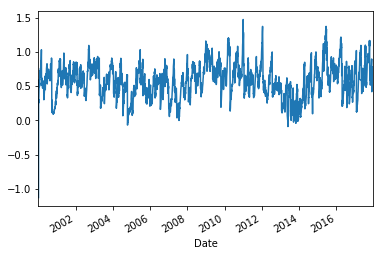

In [13]:
#plot rho

rho.plot()

In [12]:
#construct weights
w1t= sigma2.shift(-1)/(sigma1.shift(-1)+ sigma2.shift(-1))
w2t=1-w1t
#Contruct portfolio return series
R_port=w1t*R1t.shift(-1)+w2t*R2t.shift(-1)
sigma_port=np.sqrt(w1t**2*sigma1.shift(-1)**2+w2t**2*sigma2.shift(-1)**2+2*w1t*w2t*sigma1.shift(-1)*sigma2.shift(-1)*rho.shift(-1))


C:\Users\sunju\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [15]:
## add w1t to data with nan; add sigma1 and sigma2 to data
data['w1t']=np.nan
data['sigma1']=sigma1
data['sigma2']=sigma2
w1t=data['w1t']
sigma1=data['sigma1']
sigma2=data['sigma2']
##apply the formula
for i in range(len(data)):
    if i+1 < len(w1t):
        w1t.loc[w1t.index[i]]= sigma2.loc[sigma2.index[i+1]]/(sigma1.loc[sigma1.index[i+1]]+ sigma2.loc[sigma2.index[i+1]])
data['w2t']=1-w1t
w2t=data['w2t']
data.head()

,SP500,Apple,R1t,R2t,R_port,sigma_port,w1t,sigma1,sigma2,w2t
Date,,,,,,,,,,
1999-12-31,1469.250000,2.485700,NaN,NaN,NaN,NaN,0.776019,NaN,NaN,0.223981
2000-01-03,1455.219971,2.706315,-0.416705,3.692963,-2.165170,NaN,0.780401,0.691223,2.394850,0.219599
2000-01-04,1399.420044,2.478144,-1.698056,-3.825181,0.235256,1.087840,0.722664,0.682571,2.425691,0.277336
2000-01-05,1402.109985,2.514410,0.083399,0.630956,-1.035572,1.088846,0.728870,0.971358,2.531107,0.271130
2000-01-06,1403.449951,2.296816,0.041485,-3.930989,1.375702,1.038816,0.746981,0.923230,2.481890,0.253019


In [16]:
data['R1t']=R1t
data['R2t']=R2t
data['R_port']=np.nan
data['sigma_port']=np.nan
R_port=data['R_port']
sigma_port=data['sigma_port']
for i in range(len(data)):
    if i+1 < len(R1t):
        R_port.loc[R_port.index[i+1]]=w1t.loc[w1t.index[i]]*R1t.loc[R1t.index[i+1]]+w2t.loc[w2t.index[i]]*R2t.loc[R2t.index[i+1]]
        sigma_port.loc[sigma_port.index[i+1]]=np.sqrt(w1t.loc[w1t.index[i]]**2*sigma1.loc[sigma1.index[i+1]]**2+w2t.loc[w2t.index[i]]**2*sigma2.loc[sigma2.index[i+1]]**2+2*w1t.loc[w1t.index[i]]*w2t.loc[w2t.index[i]]*sigma1.loc[sigma1.index[i+1]]*sigma2.loc[sigma2.index[i+1]]*rho.loc[rho.index[i+1]])
data.head()

C:\Users\sunju\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


,SP500,Apple,R1t,R2t,R_port,sigma_port,w1t,sigma1,sigma2,w2t
Date,,,,,,,,,,
1999-12-31,1469.250000,2.485700,NaN,NaN,NaN,NaN,0.776019,NaN,NaN,0.223981
2000-01-03,1455.219971,2.706315,-0.416705,3.692963,-2.174492,NaN,0.780401,0.691223,2.394850,0.219599
2000-01-04,1399.420044,2.478144,-1.698056,-3.825181,0.203642,0.825495,0.722664,0.682571,2.425691,0.277336
2000-01-05,1402.109985,2.514410,0.083399,0.630956,-1.060223,1.135855,0.728870,0.971358,2.531107,0.271130
2000-01-06,1403.449951,2.296816,0.041485,-3.930989,1.391080,1.066319,0.746981,0.923230,2.481890,0.253019


In [18]:
##1% VaR
d = resR1t.params[5]
tp = stats.t.ppf(0.99,d)
VaR_t = (tp*np.sqrt((d-2)/d))
print("VaR from t(d) distribution: {0:.3f}".format(VaR_t))


VaR from t(d) distribution: 2.520


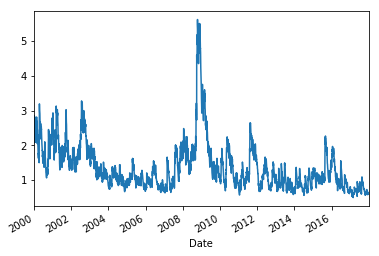

In [19]:
data['VAR']=np.nan
VAR=data['VAR']
VAR=sigma_port*VaR_t
VAR.plot()

In [20]:
#Backtest VaR
data['I']=np.nan
I=data['I']
for i in range(len(data)):
    if i+1 < len(R_port):
        if R_port.loc[R_port.index[i+1]]<-VAR.loc[VAR.index[i+1]]:
            I.loc[I.index[i+1]]=1
        elif R_port.loc[R_port.index[i+1]]>=-VAR.loc[VAR.index[i+1]]:
            I.loc[I.index[i+1]]=0  
data['I']=I
data.head()

,SP500,Apple,R1t,R2t,R_port,sigma_port,w1t,sigma1,sigma2,w2t,VAR,I
Date,,,,,,,,,,,,
1999-12-31,1469.250000,2.485700,NaN,NaN,NaN,NaN,0.776019,NaN,NaN,0.223981,NaN,NaN
2000-01-03,1455.219971,2.706315,-0.416705,3.692963,-2.174492,NaN,0.780401,0.691223,2.394850,0.219599,NaN,NaN
2000-01-04,1399.420044,2.478144,-1.698056,-3.825181,0.203642,0.825495,0.722664,0.682571,2.425691,0.277336,NaN,0.0
2000-01-05,1402.109985,2.514410,0.083399,0.630956,-1.060223,1.135855,0.728870,0.971358,2.531107,0.271130,NaN,0.0
2000-01-06,1403.449951,2.296816,0.041485,-3.930989,1.391080,1.066319,0.746981,0.923230,2.481890,0.253019,NaN,0.0


In [21]:
##unconditional coverage
T1=np.sum(I)
T=len(I)
pi_hat=T1/T
p=0.01
LR_uc=-2*np.log((p**T1*(1-p)**(T-T1))/(pi_hat**T1*(1-pi_hat)**(T-T1)))
t=(pi_hat-p)/(np.sqrt(p*(1-p))/T)
print(LR_uc,t)
##the 5% critical value for t test and LR test are 1.96 and 3..84 respectively. 
##They both lie in rejection region. So unconditional coverage are rejected.

0.16065460232245474 27.236524793524627


In [22]:
##independence testing
I1=I.shift(1).dropna()
x=I1
y=I.dropna()
y=list(y)
x = sm.add_constant(x)
mod=sm.OLS(y, x)
result= mod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.102e+33
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:34:56   Log-Likelihood:             1.5702e+05
No. Observations:                4526   AIC:                        -3.140e+05
Df Residuals:                    4524   BIC:                        -3.140e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.732e-17    3.1e-18     -8.806      0.0

C:\Users\sunju\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
#test hypothesis
H=['I=0']
ttest=result.t_test(H)
print(ttest)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0000   3.01e-17   3.32e+16      0.000       1.000       1.000


t statistic for coefficient of I is in the rejection range, so independence test is rejected. The t statistic obtained here is extremely large, there might be autocorrelation problem.
Since unconditional coverage and independence test are both rejected, expected shortfall test thus is also rejected.